In [1]:
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.interpolate import Rbf
from matplotlib.colors import LogNorm

from astropy.coordinates import get_sun
from astropy.coordinates import get_moon
from astropy.coordinates import EarthLocation
import astropy.coordinates as ac
from astropy.coordinates.angles import Angle
import astropy.time as at
from astropy.io import fits
import h5py
from scipy.io import loadmat
import codecs
import re

In [2]:
print 'start @ ' + time.asctime(time.localtime(time.time())) +'#'

start @ Mon Jun 20 18:13:19 2022#


In [3]:
print  plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth']
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth']

10.0 0.8 1.5
14.0 1.5 1.5


In [4]:
import csv
import pandas

In [5]:
def power2db(power):
    return np.log10(power)*10.

def db2power(db):
    return 10**(db/10.)

In [6]:
for i in [100, 50, 1, 0, -1,-50,-100]:
    ii=db2power(i)
    iii=power2db(ii)
    print i, iii

100 100.0
50 50.0
1 1.0
0 0.0
-1 -1.0
-50 -50.0
-100 -100.0


In [7]:
freq=1100

In [8]:
beam_table=pandas.read_csv('./data39/'+str(freq)+'.csv')


In [9]:
beam_table[:10]

,Freq [GHz],Phi [deg],Theta [deg],dB(GainL3X) [],dB(GainL3Y) []
0,1.1,0,-180.0,-2.028160,-13.554146
1,1.1,0,-179.9,-1.587262,-13.242770
2,1.1,0,-179.8,-1.383270,-13.000523
3,1.1,0,-179.7,-1.481504,-12.948305
4,1.1,0,-179.6,-1.726089,-13.021103
5,1.1,0,-179.5,-1.859530,-13.034455
6,1.1,0,-179.4,-1.772872,-12.864936
7,1.1,0,-179.3,-1.620859,-12.578625
8,1.1,0,-179.2,-1.617631,-12.336955
9,1.1,0,-179.1,-1.826277,-12.235169


In [10]:
beam_table[-10:]

,Freq [GHz],Phi [deg],Theta [deg],dB(GainL3X) [],dB(GainL3Y) []
262863,1.1,360,179.1,-3.431850,-14.208098
262864,1.1,360,179.2,-3.405321,-14.295475
262865,1.1,360,179.3,-3.076041,-14.333467
262866,1.1,360,179.4,-2.599082,-14.175039
262867,1.1,360,179.5,-2.231457,-13.866287
262868,1.1,360,179.6,-2.140760,-13.612962
262869,1.1,360,179.7,-2.308108,-13.561327
262870,1.1,360,179.8,-2.504918,-13.665972
262871,1.1,360,179.9,-2.427107,-13.719543
262872,1.1,360,180.0,-2.028160,-13.554146


In [11]:
for i in  beam_table.columns:
    print i

Freq [GHz]
Phi [deg]
Theta [deg]
dB(GainL3X) []
dB(GainL3Y) []


In [12]:
freqs_GHz=(beam_table['Freq [GHz]']).astype(float)
assert((freqs_GHz==freq/1e3).all())

In [13]:
ph=(beam_table['Phi [deg]']).astype(float)
th=(beam_table['Theta [deg]']).astype(float)
gxx=(beam_table['dB(GainL3X) []']).astype(float)
gxy=(beam_table['dB(GainL3Y) []']).astype(float)


In [14]:
ph_map=ph.reshape([73,3601])
th_map=th.reshape([73,3601])
gxx=gxx.reshape([73,3601])
gxy=gxy.reshape([73,3601])

/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


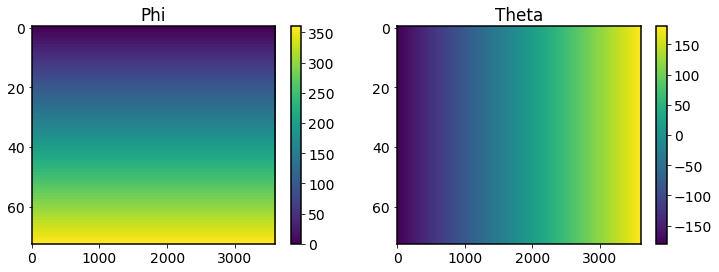

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(ph_map,aspect='auto')
plt.title('Phi')
plt.colorbar()
plt.subplot(122)
plt.imshow(th_map,aspect='auto')
plt.title('Theta')
plt.colorbar()
plt.show()

In [16]:
ph=ph_map[:,0]
th=th_map[0,:]
print np.shape(ph),np.shape(th)

(73,) (3601,)


In [17]:
print np.min(ph),np.max(ph)

0.0 360.0


In [18]:
print np.min(th),np.max(th)

-180.0 180.0


In [19]:
print np.shape(gxx),np.shape(gxy)

(73, 3601) (73, 3601)


In [20]:
ph

array([   0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
         45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
         90.,   95.,  100.,  105.,  110.,  115.,  120.,  125.,  130.,
        135.,  140.,  145.,  150.,  155.,  160.,  165.,  170.,  175.,
        180.,  185.,  190.,  195.,  200.,  205.,  210.,  215.,  220.,
        225.,  230.,  235.,  240.,  245.,  250.,  255.,  260.,  265.,
        270.,  275.,  280.,  285.,  290.,  295.,  300.,  305.,  310.,
        315.,  320.,  325.,  330.,  335.,  340.,  345.,  350.,  355.,  360.])

In [21]:
th

array([-180. , -179.9, -179.8, ...,  179.8,  179.9,  180. ])

In [22]:
gxx_cur=np.mean(gxx,axis=0)
gxy_cur=np.mean(gxy,axis=0)
print np.shape(gxx_cur),np.shape(gxy_cur)

(3601,) (3601,)


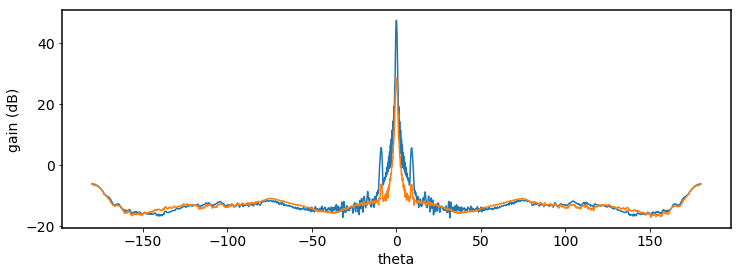

In [23]:
plt.figure(figsize=(12,4))
plt.plot(th,gxx_cur)
plt.plot(th,gxy_cur)
plt.xlabel('theta')
plt.ylabel('gain (dB)')
plt.show()

In [24]:
np.max(gxx_cur)-np.min(gxx_cur)

64.980094339419793

In [25]:
gpw_xx=db2power(gxx_cur)
gpw_xy=db2power(gxy_cur)


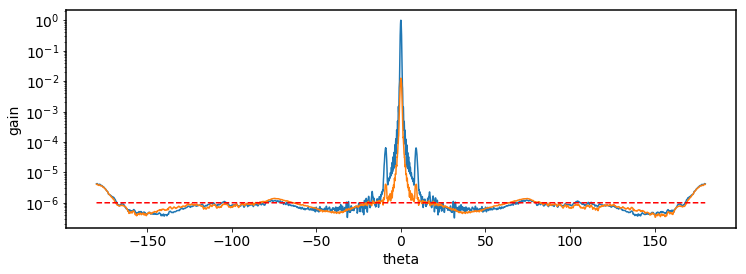

In [26]:
plt.figure(figsize=(12,4))
plt.plot(th,gpw_xx/np.max(gpw_xx))
plt.plot(th,gpw_xy/np.max(gpw_xx)) #rescale with xx
plt.plot(th,np.ones_like(th)*1e-6,'r--')
plt.xlabel('theta')
plt.ylabel('gain')
plt.yscale('log')
plt.show()

In [28]:
#gpw_x=np.sqrt(gpw_xx*2+gpw_xy**2)
gpw_x=gpw_xx+gpw_xy
gpw_x=gpw_x/np.max(gpw_x)

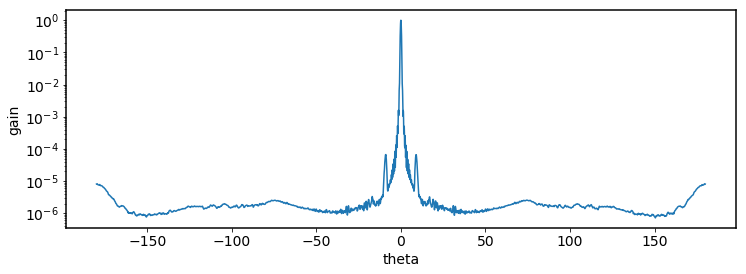

In [29]:
plt.figure(figsize=(12,4))
plt.plot(th,gpw_x)
plt.xlabel('theta')
plt.ylabel('gain')
plt.yscale('log')
plt.show()

In [30]:
T_HI=2e-3 #K
Tsun=6000 #K   #The diameter of the sun is 0.5 degrees

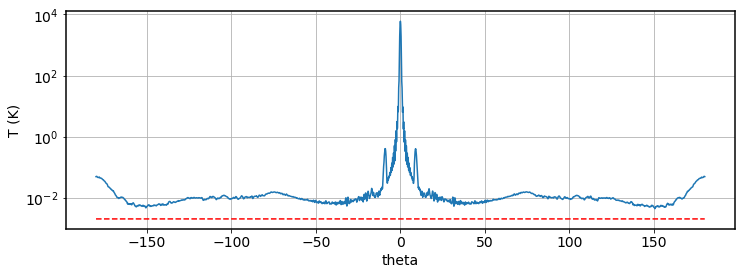

In [40]:
plt.figure(figsize=(12,4))
plt.plot(th,gpw_x*Tsun)
plt.plot(th,np.ones_like(th)*T_HI,'r--')
plt.xlabel('theta')
plt.ylabel('T (K)')
plt.yscale('log')
plt.grid()
plt.show()

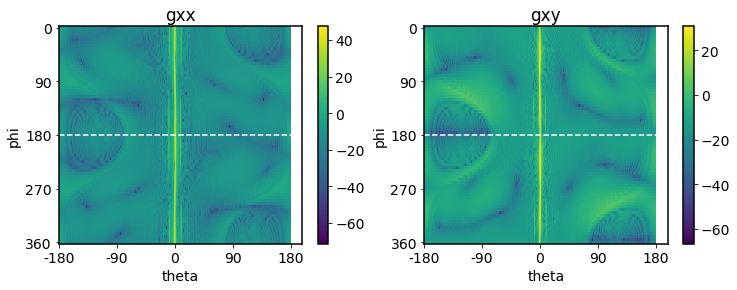

In [32]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(gxx,aspect='auto')
plt.xticks([0,900,1800,2700,3600],[-180,-90,0,90,180])
plt.yticks([0,18,36,54,72],[0,90,180,270,360])
plt.plot([0,3601],[36,36],'w--')
plt.xlabel('theta')
plt.ylabel('phi')
plt.title('gxx')
plt.colorbar()
plt.subplot(122)
plt.imshow(gxy,aspect='auto')
plt.xticks([0,900,1800,2700,3600],[-180,-90,0,90,180])
plt.yticks([0,18,36,54,72],[0,90,180,270,360])
plt.plot([0,3601],[36,36],'w--')
plt.xlabel('theta')
plt.ylabel('phi')
plt.title('gxy')
plt.colorbar()
plt.show()

/usr/lib/python2.7/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


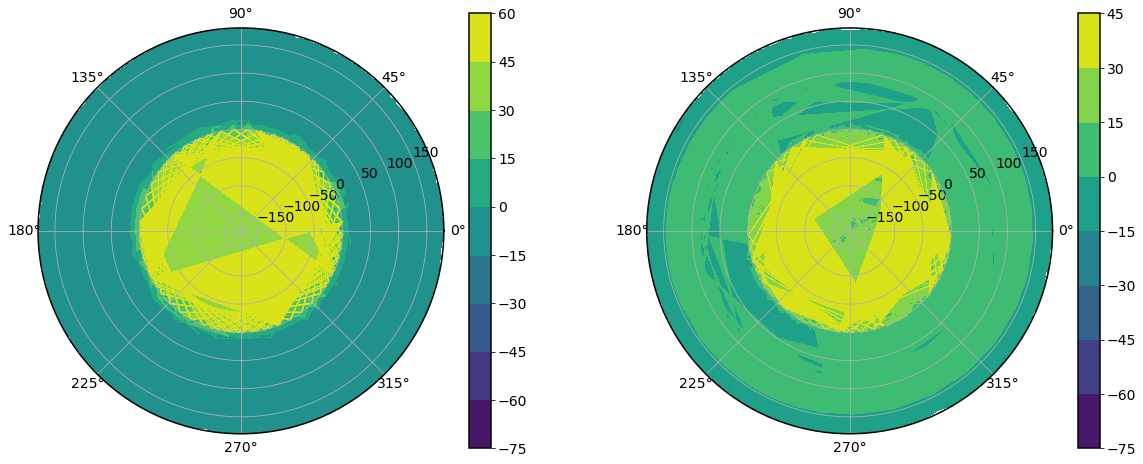

In [33]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(121, polar=True)
ctf1 = ax1.contourf(ph, th, gxx.T, aspect='auto')
plt.colorbar(ctf1)
ax2 = plt.subplot(122, polar=True)
ctf2 = ax2.contourf(ph, th, gxy.T, aspect='auto')
plt.colorbar(ctf2)
plt.show()


In [34]:
th[th<0]

array([ -1.80000000e+02,  -1.79900000e+02,  -1.79800000e+02, ...,
        -3.00000000e-01,  -2.00000000e-01,  -1.00000000e-01])

In [35]:
gxx[:,th<0]

array([[ -2.02816013,  -1.58726153,  -1.38327005, ...,  44.6855222 ,
         46.2198002 ,  47.17267765],
       [ -2.39580435,  -1.96198518,  -1.76816765, ...,  44.68575785,
         46.21847148,  47.17181077],
       [ -3.04426265,  -2.62415616,  -2.44424949, ...,  44.68449805,
         46.21707199,  47.17130441],
       ..., 
       [ -2.06689818,  -1.62842437,  -1.41120985, ...,  44.6805366 ,
         46.22216254,  47.17544933],
       [ -1.92047358,  -1.47818534,  -1.26657124, ...,  44.68377065,
         46.2210308 ,  47.17389284],
       [ -2.02816013,  -1.58726153,  -1.38327005, ...,  44.6855222 ,
         46.2198002 ,  47.17267765]])

In [36]:
np.min(gxx[:,th<0])

-71.543071190143792

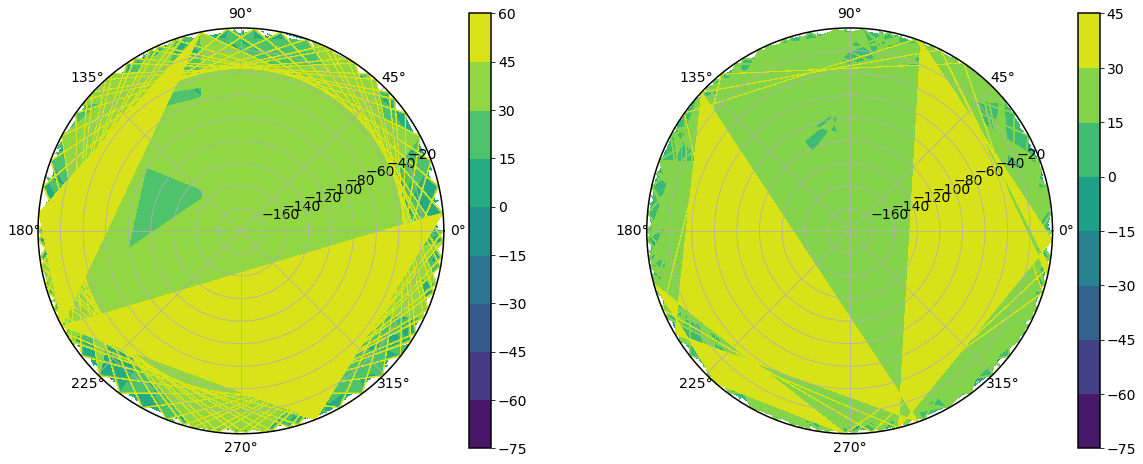

In [37]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(121, polar=True)
ctf1 = ax1.contourf(ph, th[th<0], gxx[:,th<0].T, aspect='auto')
plt.colorbar(ctf1)
ax2 = plt.subplot(122, polar=True)
ctf2 = ax2.contourf(ph, th[th<0], gxy[:,th<0].T, aspect='auto')
plt.colorbar(ctf2)
plt.show()


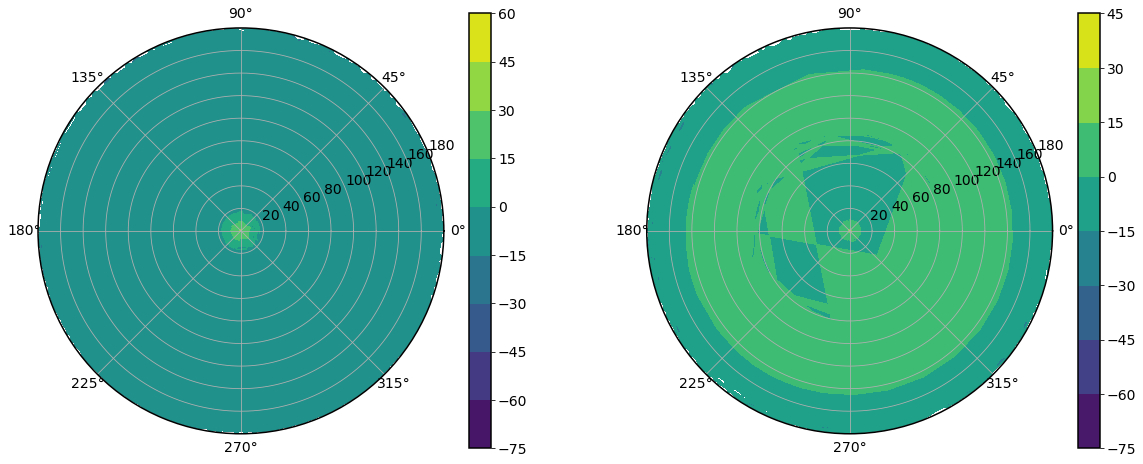

In [38]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(121, polar=True)
ctf1 = ax1.contourf(ph, th[th>0], gxx[:,th>0].T, aspect='auto')
plt.colorbar(ctf1)
ax2 = plt.subplot(122, polar=True)
ctf2 = ax2.contourf(ph, th[th>0], gxy[:,th>0].T, aspect='auto')
plt.colorbar(ctf2)
plt.show()